SPHEREx Machine Learning Project V2
Last Edited 12/31/2024
@marcoc7 @james buda

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%load_ext autoreload


In [6]:
%autoreload 2

In [4]:
import sys
from pathlib import Path

base_dir = Path.cwd()
autolens_config_path = base_dir / "autolens_config"
spherex_path = base_dir / "SPHEREx"

sys.path.append(str(autolens_config_path))
sys.path.append(str(spherex_path))


#import gcluster15  # from autolens_config
import SPHERExScripts as SPHEREx  # from SPHEREX
import gcluster11 as galaxy
import autolens_config

In [3]:
#Determine Valid SPHEREx Final Image Sizes: 
sphereX_pixels_list = [16,32,64,128, 256, 512, 1024,2048]
original_image_sizes = {px: SPHEREx.calculate_original_image_pixels(px) for px in sphereX_pixels_list}
for px, orig in original_image_sizes.items():
     print(f"SPHEREx Pixels: {px}, Original Image Pixels: {orig}")


# SPHEREx Pixels: 32, Original Image Pixels: 395
# SPHEREx Pixels: 64, Original Image Pixels: 683
# SPHEREx Pixels: 128, Original Image Pixels: 1259    
#For this project, we probably need to go with 395 or 683 for the generated image size. 

SPHEREx Pixels: 16, Original Image Pixels: 251
SPHEREx Pixels: 32, Original Image Pixels: 395
SPHEREx Pixels: 64, Original Image Pixels: 683
SPHEREx Pixels: 128, Original Image Pixels: 1259
SPHEREx Pixels: 256, Original Image Pixels: 2411
SPHEREx Pixels: 512, Original Image Pixels: 4715
SPHEREx Pixels: 1024, Original Image Pixels: 9323
SPHEREx Pixels: 2048, Original Image Pixels: 18539


### Generation of Data Stuff: 

The code in this section is used to create generateSPHERExLensv3.py

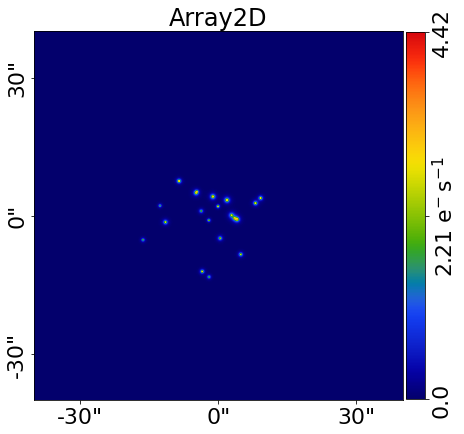

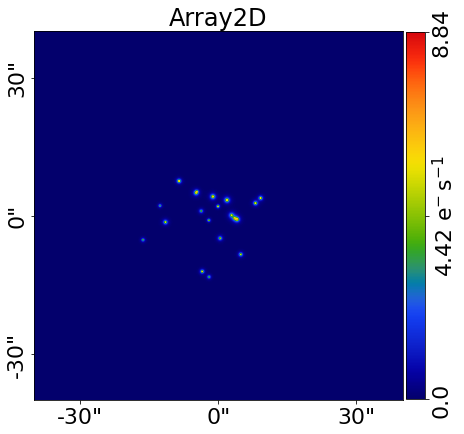

In [8]:
#Generate galaxy cluster with no lensing: 
# imageRaw = galaxy.simulate_realistic_cluster_no_lensing()
imageRaw = galaxy.wrapperFunction(20)

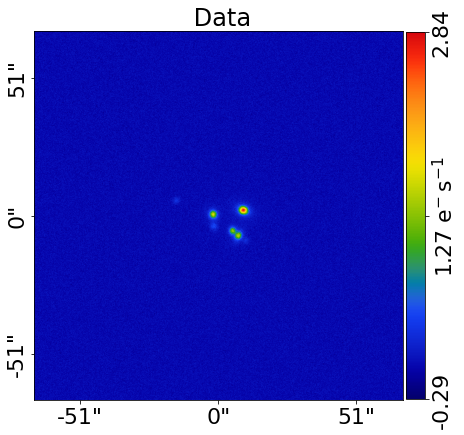

In [6]:
#generate galaxy cluster with lensing: 

# For gcluster13 and beyond, outputs alot of image data
imageRaw = galaxy.wrapperFunction()  # Returns a PyAutoLens Imaging object
#print(raw)

In [15]:
#Extract the 2D Numpy Array from Imaging Data
#raw = imageRaw.data.native.astype(np.ndarray)
raw = np.array(imageRaw.data.native)
raw.shape #just to verify that it is in a compatible shape

(683, 683)

In [16]:
#Convert image to SPHEREx Resolution (3.1"/pixel), adds simulated PSF according to SPHEREx Dataset
convolved, binned = SPHEREx.processImg(raw)

In [20]:
#Add Noise. For all practical intents and purposes, we will assume constant dark current: 
darkCurrentRate = 0.02  # e-/s/pixel (from: https://ar5iv.labs.arxiv.org/html/1412.4872)
integrationTime = 5  # seconds, this is prob pseudo-completely arbitary? 
noiseParameter = darkCurrentRate*integrationTime #note, larger parameter = more noise

noisyArray = SPHEREx.addNoise(binned,mode="constantdarkcurrent",parameter = noiseParameter)

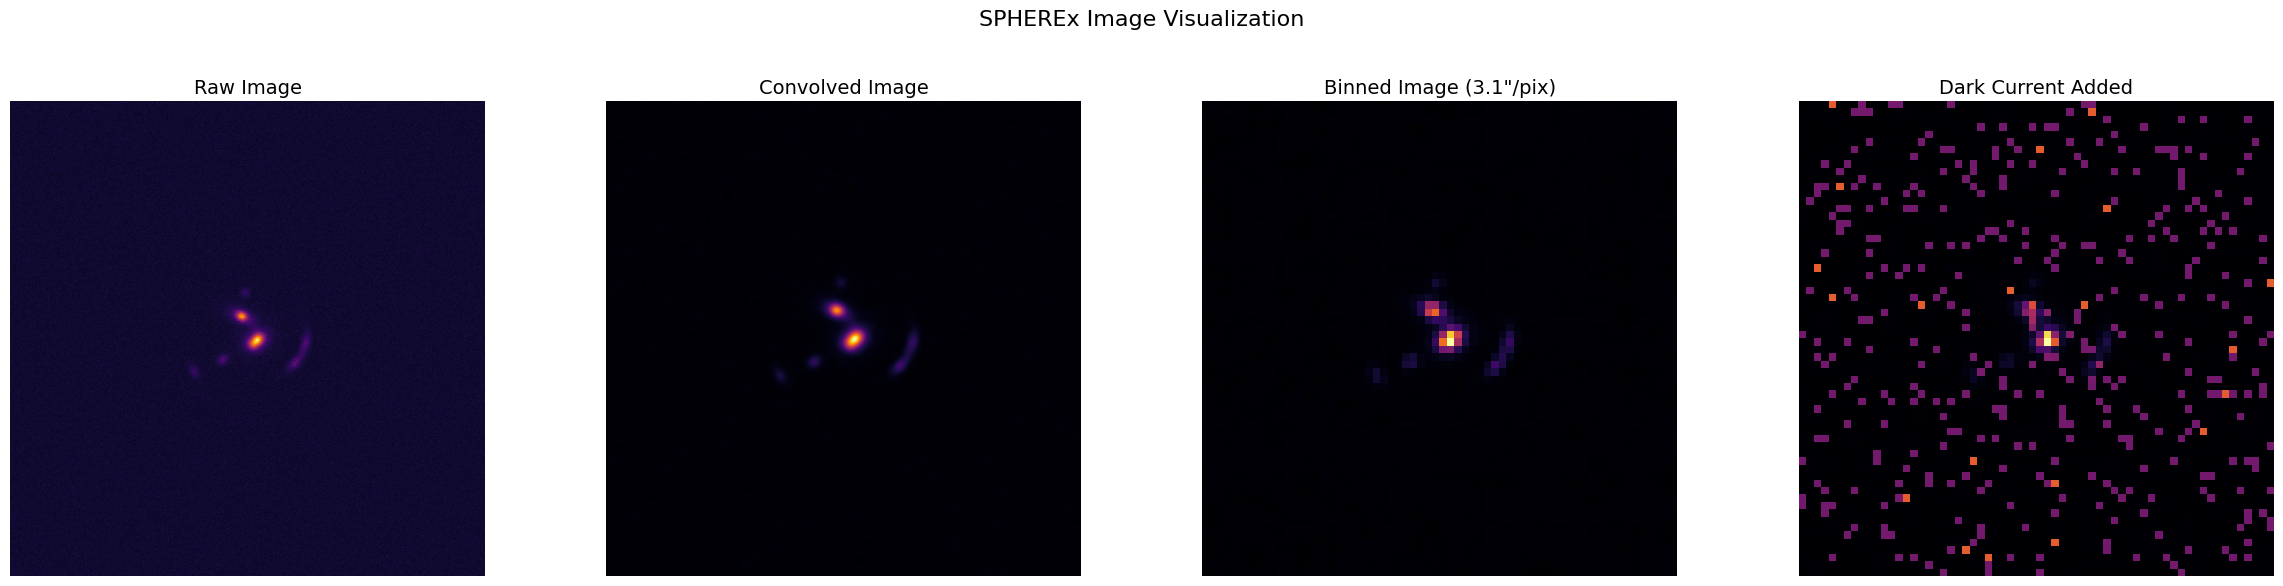

In [21]:
SPHEREx.plotImg(raw_image=raw,convolved=convolved,binned=binned, noisy_array = noisyArray)

In [10]:
raw_flux = raw.sum()
binned_flux = binned.sum()
print(f"Raw Flux: {raw_flux}, Binned Flux: {binned_flux}")


Raw Flux: 2510.812984728383, Binned Flux: 30.455862022307862


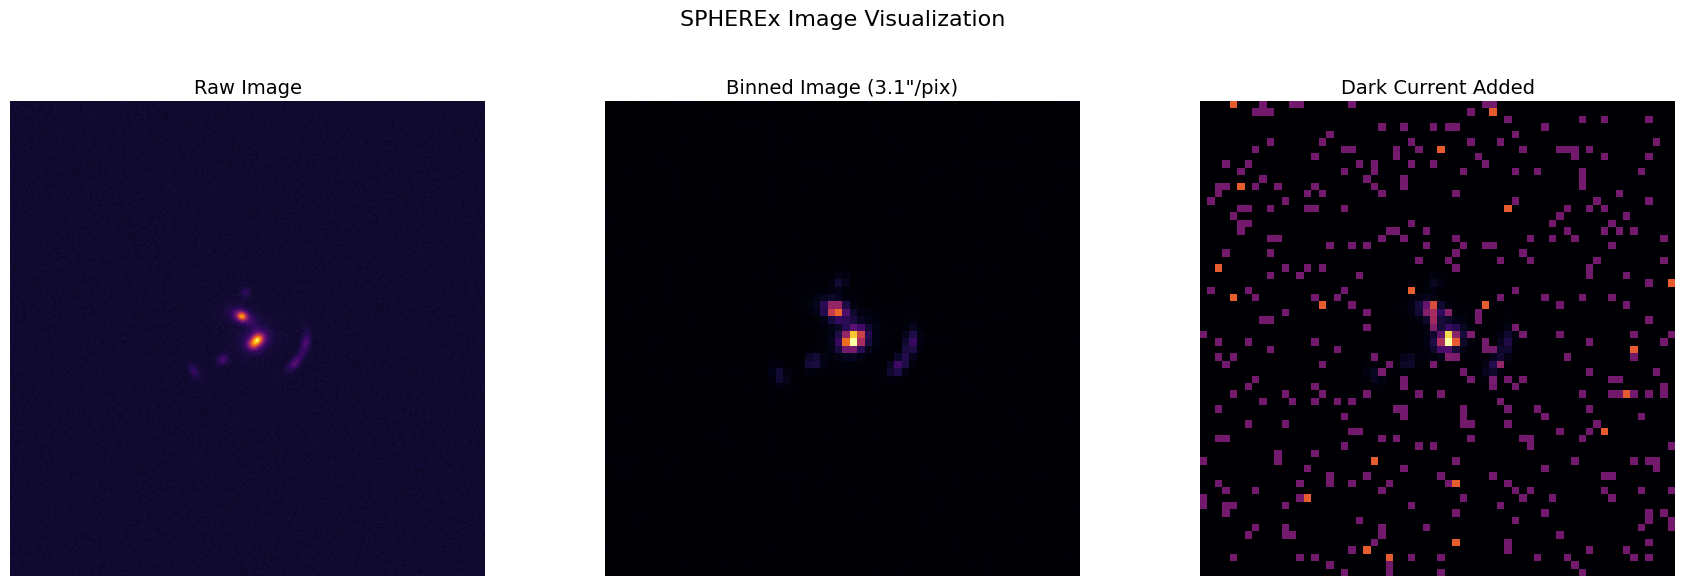

In [23]:
SPHEREx.plotImg(raw_image=raw, binned=binned, noisy_array = noisyArray)

### Data Processing Stuff: 

Please execute/refer/edit to generateSPHERExLensv3.py to generate the relevant .h5 file. 

In [12]:
%run generateSPHERExLensv3.py

Processing images:   0%|          | 0/5 [00:00<?, ?it/s]

Processing images: 100%|██████████| 5/5 [00:46<00:00,  9.38s/it]

Results successfully saved to output/test4.h5


In [4]:
def compare_lines(data, index1, index2):
    """
    Compare two lines in a list of dictionaries to check if their values are the same.

    Parameters:
        data (list): List of dictionaries.
        index1 (int): Index of the first line to compare.
        index2 (int): Index of the second line to compare.

    Returns:
        dict: A dictionary indicating whether values match for each key.
    """
    if index1 >= len(data) or index2 >= len(data):
        raise IndexError("Index out of range for the provided data.")

    # Extract the dictionaries to compare
    line1 = data[index1]
    line2 = data[index2]

    # Compare values for each key
    comparison = {}
    for key in line1.keys():
        if isinstance(line1[key], np.ndarray):
            comparison[key] = np.array_equal(line1[key], line2[key])
        else:
            comparison[key] = line1[key] == line2[key]

    return comparison


In [14]:
#Run this cell, and the two cells above this to verify if Multiprocessing works. As of 1/2/2025, it works
comparison_result = compare_lines(results, 0, 4)
print(comparison_result)

{'index': False, 'isLensed': False, 'simulated_array': False, 'spherex_array': False}


In [24]:
import h5py 
with h5py.File("output/test5.h5", "r") as hdf:
    indices = hdf["indices"][:]
    is_lensed = hdf["isLensed"][:]
    simulated_arrays = hdf["simulated_arrays"][:]
    spherexBinned_arrays = hdf["SPHEREx_Array_binned"][:]
    spherexDC_arrays = hdf["SPHEREx_Array_dc"][:]


print("Indices:", indices)
print("Is Lensed:", is_lensed)
print("Simulated Array Shape:", simulated_arrays.shape)
print("SPHEREx Array Shape:", spherexBinned_arrays.shape)

Indices: [0 1 2 3 4]
Is Lensed: [0 1 0 1 0]
Simulated Array Shape: (5, 683, 683)
SPHEREx Array Shape: (5, 64, 64)


is_Lensed = 0


(-0.5, 63.5, 63.5, -0.5)

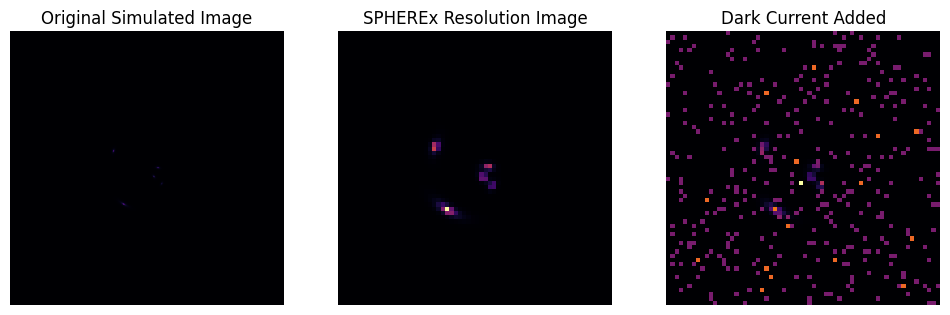

In [25]:
idx = 4
print(f'is_Lensed = {is_lensed[idx]}')

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
#fig.suptitle(f"SPHEREx Image Visualization\nIndex = {indice}, Lensed = {lensed_status}", fontsize=16)

axes[0].imshow(simulated_arrays[idx], cmap="inferno")
axes[0].set_title("Original Simulated Image")
axes[0].axis("off")

axes[1].imshow(spherexBinned_arrays[idx], cmap="inferno")
axes[1].set_title("SPHEREx Resolution Image")
axes[1].axis("off")

axes[2].imshow(spherexDC_arrays[idx], cmap="inferno")
axes[2].set_title("Dark Current Added")
axes[2].axis("off")

#okay something is clearly wrong....

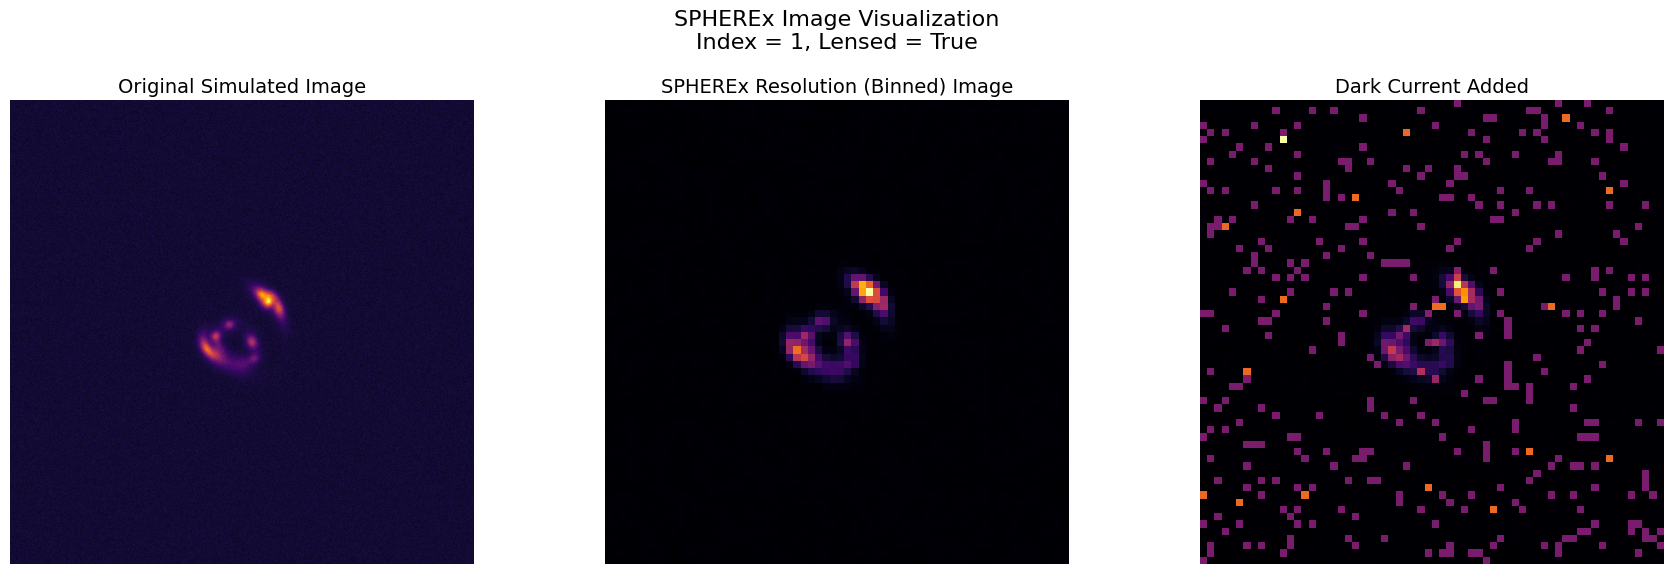

In [30]:
idx = 1

SPHEREx.plotSPHERExData(
    indices=indices,
    is_lensed=is_lensed,
    simulated_arrays=simulated_arrays,
    spherexBinnedArrays=spherexBinned_arrays,
    spherexDC_arrays=spherexDC_arrays,
    indice=idx # Specify the index to plot
)

### Model Training Stuff

I have no clue what this stuff is at the bottom lol

This was me testing how to make a cell not run - James

In [20]:
%%script false --no-raise-error
n = 5

In [21]:
print(n)

NameError: name 'n' is not defined